### 강사님이 보내신 파일에 업로드 관련 정보가 없어서 영상과 다르게 제일 윗 부분을 추가하였습니다

In [1]:
#여기서 필요한 파일은 required files 폴더 안에 있는 것 중 physio_small.h5, phyionet_genrator.py, physionet_processing.py, REFERNECE-small.csv 파일입니다
# 아래처럼 마운트된 것에서 불러 오셔도 되고 
from google.colab import drive
drive.mount('/content/gdrive')

#또는 아래에서 다운로도ㅡ된 파일을 불러오셔도 됩니다. 여기서는 마운트하여 불러 오겠습니다
# from google.colab import files
# files.upload() 

Mounted at /content/gdrive


In [2]:
#아래 링크는 개인마다 다르므로 그 경로를 확인해 보시기 바랍니다. 좌측 패널의 위쪽에서 데이터 그림을 클릭하고 해당 zip파일의 경로를 복사하세요
!unzip "/content/gdrive/My Drive/Required_files.zip" -d required_files/

Archive:  /content/gdrive/My Drive/Required_files.zip
  inflating: required_files/history.csv  
  inflating: required_files/physionet_generator.py  
  inflating: required_files/physionet_processing.py  
  inflating: required_files/physio_small.h5  
  inflating: required_files/REFERENCE-small.csv  
  inflating: required_files/REFERENCE-v3.csv  


In [17]:
# 필요한 파일들을 불러 옵니다
physio_small = '/content/required_files/physio_small.h5'
label_file = '/content/required_files/REFERENCE-small.csv'
! cp /content/required_files/physionet_generator.py -d physionet_generator.py
! cp /content/required_files/physionet_processing.py -d physionet_processing.py

In [18]:
import numpy as np
import pandas as pd
import os
import h5py
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers

# Tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Custom imports
from physionet_processing import (fetch_h5data, spectrogram, 
                                  special_parameters, transformed_stats)

from physionet_generator import DataGenerator

print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7125648337304691352
]
Tensorflow version: 2.4.0
Keras version: 2.4.3


### Open hdf5 file, load the labels and define training/validation splits ###

In [19]:
# Data folder and hdf5 dataset file
data_root = os.path.normpath('.')
#data_root = os.path.normpath('/media/sf_vbshare/physionet_data/')
#data_root = os.path.normpath('/home/ubuntu/projects/csproject')
# 위에 바뀌어서 따라서 바꿈
hd_file = physio_small
label_file =label_file

# Open hdf5 file
h5file =  h5py.File(hd_file, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

# Load the labels
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
# Filter the labels that are in the small demo set
label_df = label_df[label_df['name'].isin(dataset_list)]

# Encode labels to integer numbers
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', label_df.iloc[100:110,])

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

Unique labels: ['A' 'N' 'O' '~']
Unique codings: [0 1 2 3]
Dataset labels:
        name label  encoded
100  A00101     A        0
101  A00102     A        0
102  A00103     O        2
103  A00104     N        1
104  A00105     N        1
105  A00106     ~        3
106  A00107     A        0
107  A00108     O        2
108  A00109     N        1
109  A00110     O        2


### Set up batch generators ###

In [20]:
# Parameters needed for the batch generator

# Maximum sequence length
max_length = 18286

# Output dimensions
sequence_length = max_length
spectrogram_nperseg = 64 # Spectrogram window
spectrogram_noverlap = 32 # Spectrogram overlap
n_classes = len(label_df.label.unique())
batch_size = 32

# calculate image dimensions
data = fetch_h5data(h5file, [0], sequence_length)
_, _, Sxx = spectrogram(data, nperseg = spectrogram_nperseg, noverlap = spectrogram_noverlap)
dim = Sxx[0].shape

print('Maximum sequence length:', max_length)

Maximum sequence length: 18286


In [21]:
params = {'batch_size': batch_size,
          'dim': dim,
          'nperseg': spectrogram_nperseg,
          'noverlap': spectrogram_noverlap,
          'n_channels': 1,
          'sequence_length': sequence_length,
          'n_classes': n_classes,
          'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', np.dtype(X[0,0,0,0]))

X shape: (32, 570, 33, 1)
y shape: (32, 4)
X type: float64


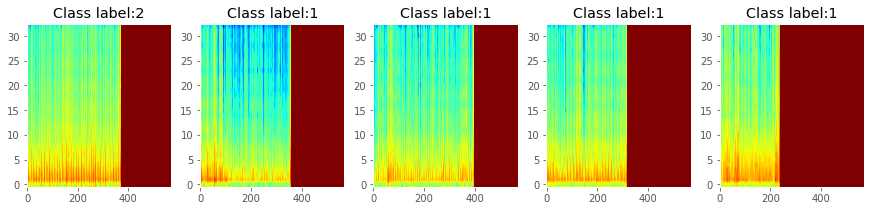

In [22]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]
    #batch_labels = ['Class label:' + str(np.argmax(y[idx,])[0]) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (15, 3))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        ax[i].grid(False)
        #ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set(title = batch_labels[i])
    
    plt.show()
        
    return fig

batch_idx = [0, 1, 2, 3, 4]
fig = imshow_batch(X, y, batch_idx)
plt.show()

### Define the model ###

In [23]:
# Convolutional blocks
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    # Fixed parameters for convolution
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            # First layer needs an input_shape 
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            # All other layers will not need an input_shape parameter
            if l == depth - 1:
                # Last layer in each block is different: adding filters and using stride 2
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        # Continue with batch normalization and activation for all layers in the block
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

In [24]:
# Define the model
# Model parameters
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 4 # Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks
n_channels = 1 # Number of color channgels
input_shape = (*dim, n_channels) # input shape for first layer


model = Sequential()

for block in range(n_blocks):

    # Provide input only for the first layer
    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    # Increase the number of filters after each block
    layer_filters += filters_growth



# Remove the frequency dimension, so that the output can feed into LSTM
# Reshape to (batch, time steps, filters)
model.add(layers.Reshape((-1, 224)))
model.add(layers.core.Masking(mask_value = 0.0))
model.add(MeanOverTime())

# Alternative: Replace averaging by LSTM

# Insert masking layer to ignore zeros
#model.add(layers.core.Masking(mask_value = 0.0))

# Add LSTM layer with 3 neurons
#model.add(layers.LSTM(200))
#model.add(layers.Flatten())

# And a fully connected layer for the output
model.add(layers.Dense(4, activation='sigmoid', kernel_regularizer = regularizers.l2(0.1)))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 570, 33, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 570, 33, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 570, 33, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 570, 33, 32)       128       
_________________________________________________________________
activation_1 (Activation)    (None, 570, 33, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 570, 33, 32)       9

In [25]:
# Compile the model and run a batch through the network
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

In [26]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = 50,
                              epochs = 10,
                              validation_data = val_generator,
                              validation_steps = 50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 116s 2s/step - loss: 2.0697 - acc: 0.4393 - val_loss: 2.0359 - val_acc: 0.6375


In [27]:
df = pd.DataFrame(history.history)
df.head()
df.to_csv('demo_history.csv')